In [11]:
# Comprobar y configurar GPU
import tensorflow as tf

print("✅ Versión de TensorFlow:", tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("🚀 GPU detectada:", gpus)
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"GPUs lógicas disponibles: {len(logical_gpus)}")
    except RuntimeError as e:
        print("⚠️ Error al configurar memory_growth:", e)
else:
    print("⚠️ No se detectó GPU. Ve a Runtime > Change runtime type > Hardware accelerator: GPU")

✅ Versión de TensorFlow: 2.19.0
🚀 GPU detectada: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPUs lógicas disponibles: 1


In [24]:
# Descomprimir dataset formato zip
import zipfile
import os

zip_path = '/content/archive.zip'
extract_path = '/content/' # Directory to extract to

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"✅ Archivo descomprimido en: {extract_path}")

BadZipFile: File is not a zip file

In [26]:
# Descomprimir dataset formato rar
!apt-get update
!apt-get install unrar

import os

rar_path = '/content/archive.rar'
extract_path = '/content/'

if os.path.exists(rar_path):
    !unrar x {rar_path} {extract_path}
    print(f"✅ Archivo descomprimido en: {extract_path}")
else:
    print(f"⚠️ Error: El archivo {rar_path} no se encontró.")

Streaming output truncated to the last 5000 lines.
Extracting  /content/angry/angry_00522.jpg                                87%  OK 
Extracting  /content/angry/angry_00523.jpg                                87%  OK 
Extracting  /content/angry/angry_00524.jpg                                87%  OK 
Extracting  /content/angry/angry_00525.jpg                                87%  OK 
Extracting  /content/angry/angry_00526.jpg                                87%  OK 
Extracting  /content/angry/angry_00527.jpg                                87%  OK 
Extracting  /content/angry/angry_00528.jpg                                87%  OK 
Extracting  /content/angry/angry_00529.jpg                                87%  OK 
Extracting  /content/angry/angry_00530.jpg                                87%  OK 
Extracting  /content/angry/angry_00531.jpg                                87%  OK 
Extracting  /content/angry/an

In [45]:
# Importar librerías de TensorFlow / Keras
import tensorflow as tf
import pathlib
import pandas as pd
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

import pathlib

import tensorflow as tf
import pathlib

data_dir = "/content/processed_data"
data_dir = pathlib.Path(data_dir)

IMG_SIZE = (96, 96)
BATCH_SIZE = 32
SEED = 123

# Carga todo el dataset sin validación
full_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    shuffle=True,
    seed=SEED
)

# Splits
dataset_size = len(full_ds)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

print(f"Total batches: {dataset_size}")
print(f"Train: {train_size} | Val: {val_size} | Test: {test_size}")

# Divide el dataset
train_ds = full_ds.take(train_size)
remaining = full_ds.skip(train_size)
val_ds = remaining.take(val_size)
test_ds = remaining.skip(val_size)

# Optimiza el rendimiento
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.prefetch(buffer_size=AUTOTUNE)

# Verifica las clases detectadas
class_names = full_ds.class_names
n_classes = len(class_names)
print("Clases (emociones) detectadas:", class_names)


Found 41210 files belonging to 6 classes.
Total batches: 1288
Train: 1030 | Val: 128 | Test: 130
Clases (emociones) detectadas: ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise']


In [51]:
# Consutrución y compilación del modelo

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = tf.keras.Sequential([
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalMaxPool2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(n_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ ?                      │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [52]:
# Funciones de ayuda en el entrenmiento y entrenamiento
callbacks = [
    EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/50


1030/1030 - 31s - 30ms/step - accuracy: 0.4579 - loss: 1.3863 - val_accuracy: 0.5107 - val_loss: 1.2052 - learning_rate: 1.0000e-03
Epoch 2/50


1030/1030 - 17s - 17ms/step - accuracy: 0.5016 - loss: 1.2434 - val_accuracy: 0.5205 - val_loss: 1.1876 - learning_rate: 1.0000e-03
Epoch 3/50


1030/1030 - 18s - 17ms/step - accuracy: 0.5225 - loss: 1.2038 - val_accuracy: 0.5447 - val_loss: 1.1557 - learning_rate: 1.0000e-03
Epoch 4/50
1030/1030 - 17s - 17ms/step - accuracy: 0.5317 - loss: 1.1813 - val_accuracy: 0.5422 - val_loss: 1.1565 - learning_rate: 1.0000e-03
Epoch 5/50


1030/1030 - 18s - 17ms/step - accuracy: 0.5428 - loss: 1.1551 - val_accuracy: 0.5505 - val_loss: 1.1388 - learning_rate: 1.0000e-03
Epoch 6/50
1030/1030 - 17s - 16ms/step - accuracy: 0.5490 - loss: 1.1445 - val_accuracy: 0.5474 - val_loss: 1.1426 - learning_rate: 1.0000e-03
Epoch 7/50


1030/1030 - 17s - 17ms/step - accuracy: 0.5534 - loss: 1.1279 - val_accuracy: 0.5559 - val_loss: 1.1259 - learning_rate: 1.0000e-03
Epoch 8/50
1030/1030 - 18s - 17ms/step - accuracy: 0.5571 - loss: 1.1184 - val_accuracy: 0.5515 - val_loss: 1.1329 - learning_rate: 1.0000e-03
Epoch 9/50
1030/1030 - 17s - 16ms/step - accuracy: 0.5634 - loss: 1.1075 - val_accuracy: 0.5532 - val_loss: 1.1346 - learning_rate: 1.0000e-03
Epoch 10/50


1030/1030 - 18s - 18ms/step - accuracy: 0.5689 - loss: 1.0897 - val_accuracy: 0.5596 - val_loss: 1.1153 - learning_rate: 1.0000e-03
Epoch 11/50


1030/1030 - 18s - 17ms/step - accuracy: 0.5714 - loss: 1.0809 - val_accuracy: 0.5608 - val_loss: 1.1101 - learning_rate: 1.0000e-03
Epoch 12/50
1030/1030 - 18s - 17ms/step - accuracy: 0.5749 - loss: 1.0733 - val_accuracy: 0.5598 - val_loss: 1.1258 - learning_rate: 1.0000e-03
Epoch 13/50


1030/1030 - 18s - 17ms/step - accuracy: 0.5753 - loss: 1.0676 - val_accuracy: 0.5654 - val_loss: 1.1058 - learning_rate: 1.0000e-03
Epoch 14/50
1030/1030 - 21s - 20ms/step - accuracy: 0.5725 - loss: 1.0631 - val_accuracy: 0.5559 - val_loss: 1.1312 - learning_rate: 1.0000e-03
Epoch 15/50
1030/1030 - 17s - 17ms/step - accuracy: 0.5803 - loss: 1.0532 - val_accuracy: 0.5579 - val_loss: 1.1295 - learning_rate: 1.0000e-03
Epoch 16/50

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1030/1030 - 18s - 18ms/step - accuracy: 0.5820 - loss: 1.0428 - val_accuracy: 0.5530 - val_loss: 1.1197 - learning_rate: 1.0000e-03
Epoch 17/50


1030/1030 - 18s - 17ms/step - accuracy: 0.6051 - loss: 0.9956 - val_accuracy: 0.5703 - val_loss: 1.0983 - learning_rate: 2.0000e-04
Epoch 18/50
1030/1030 - 18s - 17ms/step - accuracy: 0.6084 - loss: 0.9817 - val_accuracy: 0.5640 - val_loss: 1.1081 - learning_rate: 2.0000e-04
Epoch 19/50
1030/1030 - 17s - 17ms/step - accuracy: 0.6092 - loss: 0.9782 - val_accuracy: 0.5715 - val_loss: 1.1167 - learning_rate: 2.0000e-04
Epoch 20/50

Epoch 20: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
1030/1030 - 18s - 18ms/step - accuracy: 0.6101 - loss: 0.9729 - val_accuracy: 0.5684 - val_loss: 1.1200 - learning_rate: 2.0000e-04
Epoch 21/50
1030/1030 - 17s - 17ms/step - accuracy: 0.6172 - loss: 0.9624 - val_accuracy: 0.5686 - val_loss: 1.1245 - learning_rate: 4.0000e-05
Epoch 22/50
1030/1030 - 18s - 17ms/step - accuracy: 0.6198 - loss: 0.9598 - val_accuracy: 0.5732 - val_loss: 1.1099 - learning_rate: 4.0000e-05
Epoch 23/50

Epoch 23: ReduceLROnPlateau reducing learning rate to 8.

130/130 - 10s - 80ms/step - accuracy: 0.5833 - loss: 1.0787
✅ Test Accuracy: 58.33%


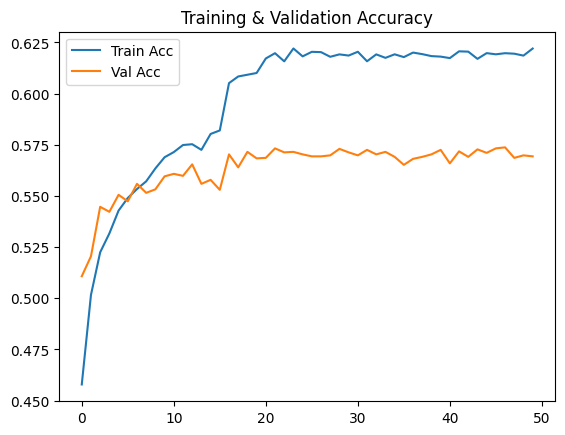

In [53]:
# Grafica de accuracy de train y val y accuracy de test

import matplotlib.pyplot as plt

loss, acc = model.evaluate(test_ds,verbose=2)
print(f"✅ Test Accuracy: {acc*100:.2f}%")

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Training & Validation Accuracy")
plt.show()

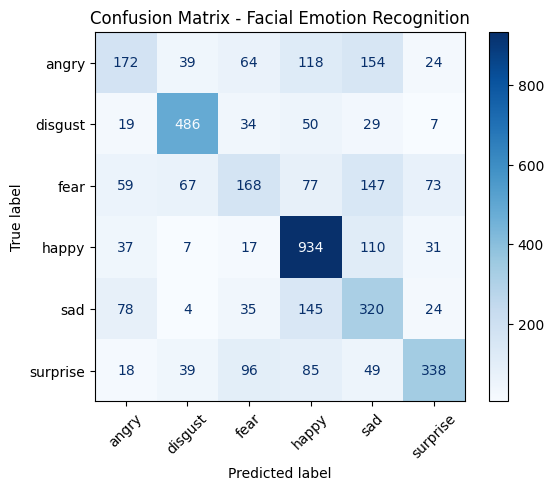

In [54]:
# Matriz de confusión

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images,verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix - Facial Emotion Recognition")
plt.show()